# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [225]:
!pip install folium

In [226]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [228]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('train.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [229]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = df.drop('dropoff_datetime', axis=1)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

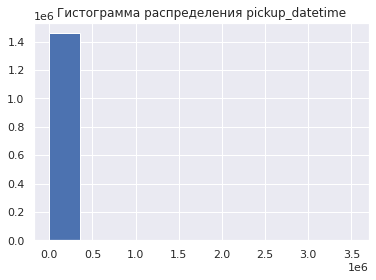

In [230]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(df['trip_duration'])
plt.title('Гистограмма распределения pickup_datetime')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

---
Распределение имеет тяжёлые хвосты или есть выбросы, обычные гистограммы не 
очень информативны. В этом случае может быть полезно нарисовать распределение в 
логарифмической шкале.


---



В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

---
Работая, в логарифмической шкале мы получим нормальное распределение целевой переменной

---


На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Расписать два функционала для заданных целевых переменных и привести их к одному виду - доложны быть одинаковые

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [231]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['log_trip_duration'] = np.log1p(df['trip_duration'])
df = df.drop('trip_duration', axis=1)

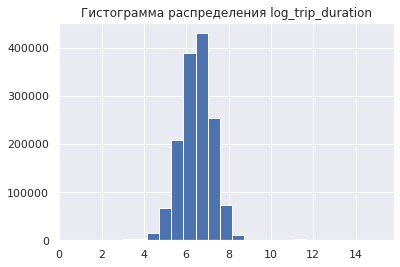

In [232]:
plt.hist(df['log_trip_duration'], bins=25)
plt.title('Гистограмма распределения log_trip_duration')
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [233]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
mean_log_trip_duration = ((df['log_trip_duration'] - df['log_trip_duration'].mean())**2).sum()/df['log_trip_duration'].shape[0]
mean_log_trip_duration

0.6332327625405546

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


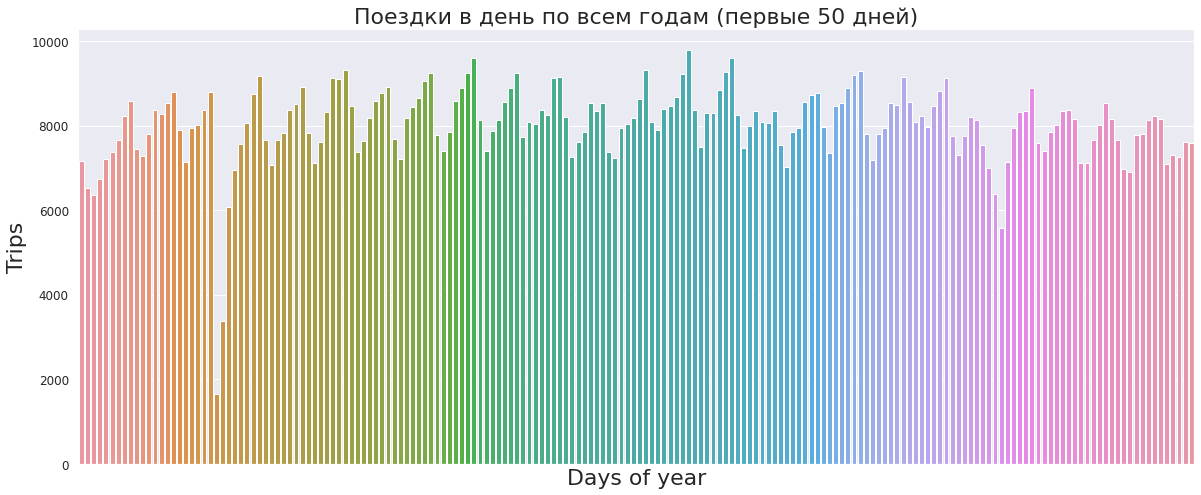

In [234]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# https://coderoad.ru/62647983/%D0%9D%D0%B0%D1%80%D0%B8%D1%81%D1%83%D0%B9%D1%82%D0%B5-%D0%B3%D1%80%D0%B0%D1%84%D0%B8%D0%BA-%D0%BF%D0%BE%D0%B4%D1%81%D1%87%D0%B5%D1%82%D0%B0-%D0%BA%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0-%D0%BF%D0%BE%D0%B5%D0%B7%D0%B4%D0%BE%D0%BA-%D0%B2-%D0%B4%D0%B5%D0%BD%D1%8C
plt.rcParams['figure.figsize']=(20,8)
plt.rcParams['axes.titlesize']=(22)
plt.rcParams['axes.labelsize']=(22)
plt.rcParams['xtick.labelsize' ]=(12)
plt.rcParams['ytick.labelsize' ]=(12)

sns.countplot(df['pickup_datetime'].dt.dayofyear, data=df)
plt.title('Поездки в день по всем годам (первые 50 дней)')
plt.ylabel('Trips')
plt.xlabel('Days of year')
plt.xticks([]) # убрать подпись значений по оси Х
# plt.xlim(0, 49)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

---
[Власти запретили автомобильное движение в Нью-Йорке из-за снежной бури](https://ria.ru/20160123/1364032228.html)

Возможно еще имелось в виду 30.05.2016г. - День поминовения в Нью-Йорке. Выходной день.

---



Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

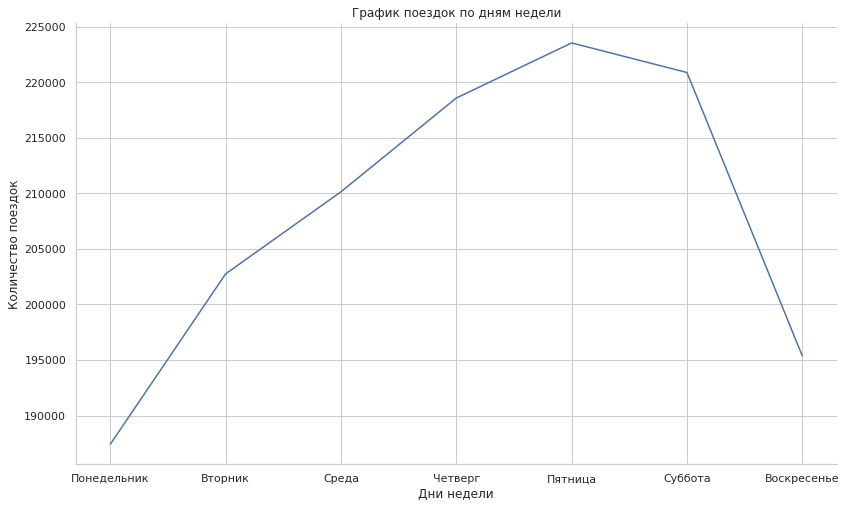

In [235]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
weekdays = df['pickup_datetime'].dt.dayofweek
count_trips = df['pickup_datetime'].groupby([weekdays]).count()

data_for_plot = count_trips.index.to_frame(name='weekdays', index=False)
count_trips.reset_index(drop=True, inplace=True)
data_for_plot = data_for_plot.merge(count_trips, left_index=True, right_index=True)
mapping = {0:'Понедельник',1:'Вторник',2:'Среда',3:'Четверг',4:'Пятница',5:'Суббота', 6:'Воскресенье'}
data_for_plot['weekdays'] = data_for_plot['weekdays'].map(mapping)

sns.set(style="whitegrid")

sns.relplot(
    x=data_for_plot['weekdays'], 
    y=data_for_plot['pickup_datetime'],
    height=7,
    aspect=1.7,
    palette=sns.color_palette(n_colors=7),
    # s=80, # размер точек
    kind="line"
    )

plt.title('График поездок по дням недели')
plt.ylabel('Количество поездок')
plt.xlabel('Дни недели')

plt.show()

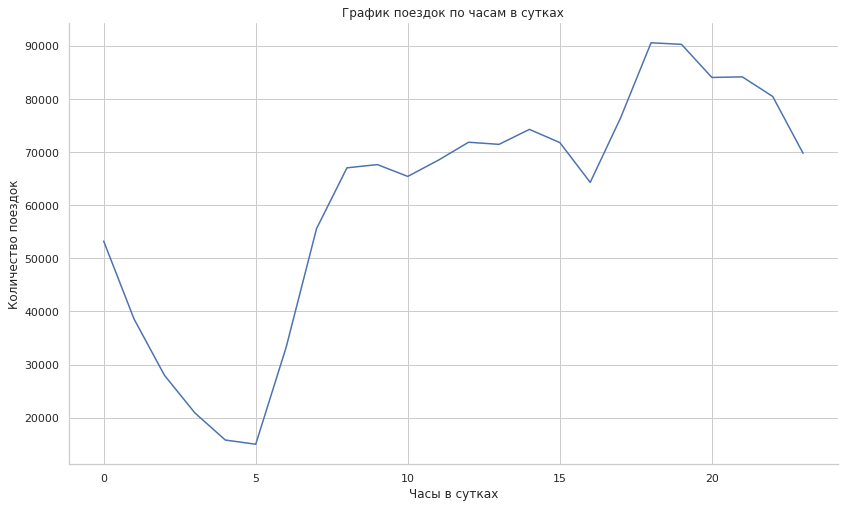

In [236]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
hours = df['pickup_datetime'].dt.hour
count_trips = df['pickup_datetime'].groupby([hours]).count()

data_for_plot = count_trips.index.to_frame(name='hours', index=False)
count_trips.reset_index(drop=True, inplace=True)
data_for_plot = data_for_plot.merge(count_trips, left_index=True, right_index=True)

sns.relplot(
    x=data_for_plot['hours'], 
    y=data_for_plot['pickup_datetime'],
    height=7,
    aspect=1.7,
    # palette=sns.color_palette(n_colors=7),
    # s=80, # размер точек
    kind="line"
    )

plt.title('График поездок по часам в сутках')
plt.ylabel('Количество поездок')
plt.xlabel('Часы в сутках')

plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

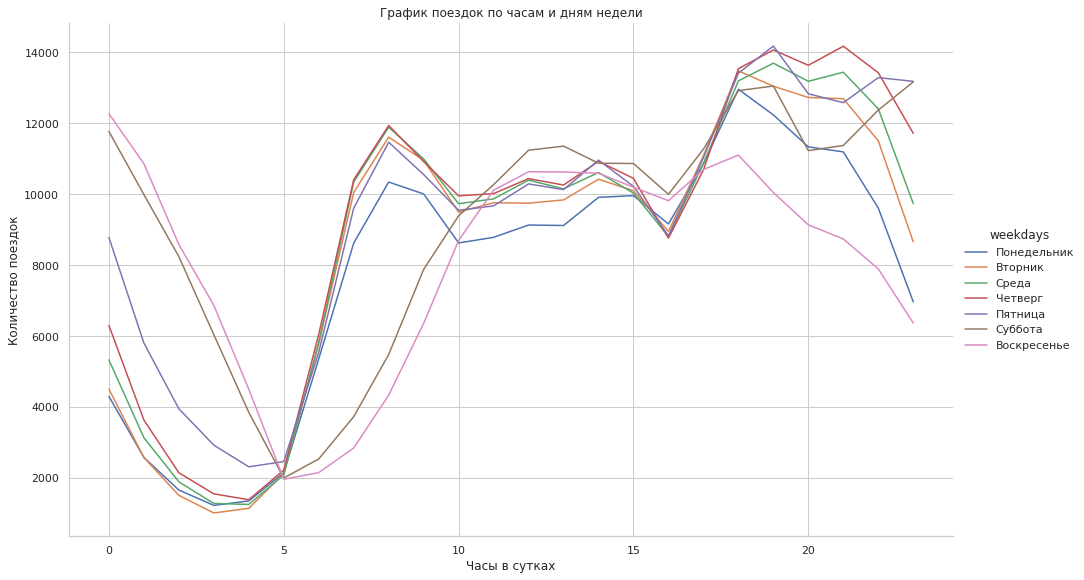

In [237]:
hours = df['pickup_datetime'].dt.hour
weekdays = df['pickup_datetime'].dt.dayofweek
count_trips = df['pickup_datetime'].groupby([hours,weekdays]).count()

data_for_plot = count_trips.index.to_frame(name=['hours', 'weekdays'], index=False)
count_trips.reset_index(drop=True, inplace=True)
data_for_plot = data_for_plot.merge(count_trips, left_index=True, right_index=True)
mapping = {0:'Понедельник',1:'Вторник',2:'Среда',3:'Четверг',4:'Пятница',5:'Суббота', 6:'Воскресенье'}
data_for_plot['weekdays'] = data_for_plot['weekdays'].map(mapping)

sns.relplot(
    x=data_for_plot['hours'], 
    y=data_for_plot['pickup_datetime'],
    hue=data_for_plot['weekdays'],
    height=8,
    aspect=1.7,
    kind="line",
    legend='full'
    )

plt.title('График поездок по часам и дням недели')
plt.ylabel('Количество поездок')
plt.xlabel('Часы в сутках')

plt.show()

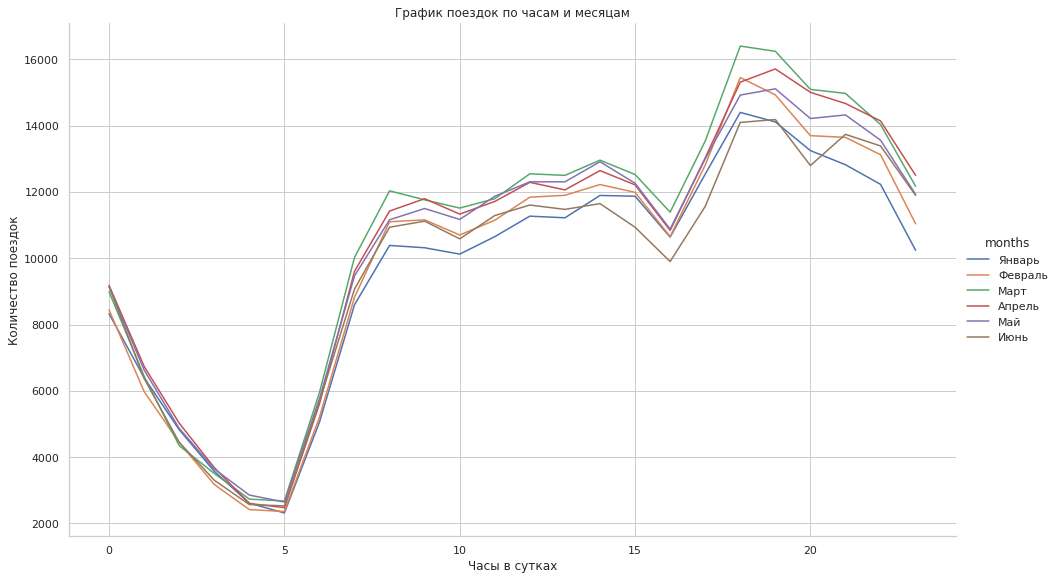

In [238]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
hours = df['pickup_datetime'].dt.hour
months = df['pickup_datetime'].dt.month
count_trips = df['pickup_datetime'].groupby([hours,months]).count()

data_for_plot = count_trips.index.to_frame(name=['hours', 'months'], index=False)
count_trips.reset_index(drop=True, inplace=True)
data_for_plot = data_for_plot.merge(count_trips, left_index=True, right_index=True)
mapping = {1:'Январь',2:'Февраль',3:'Март',4:'Апрель',5:'Май', 6:'Июнь', 7:'Июль',8:'Август',9:'Сентябрь',10:'Октябрь', 11:'Ноябрь', 12:'Декабрь'}
data_for_plot['months'] = data_for_plot['months'].map(mapping)

sns.relplot(
    x=data_for_plot['hours'], 
    y=data_for_plot['pickup_datetime'],
    hue=data_for_plot['months'],
    height=8,
    aspect=1.7,
    kind="line",
    legend='full'
    )

plt.title('График поездок по часам и месяцам')
plt.ylabel('Количество поездок')
plt.xlabel('Часы в сутках')

plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [239]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
log_trip_duration     0
dtype: int64

In [240]:
df[df['log_trip_duration'].isnull()]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration


In [241]:
df.dropna(inplace=True)
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
log_trip_duration     0
dtype: int64

In [242]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split

X=df.drop('log_trip_duration', 1)
y=df['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

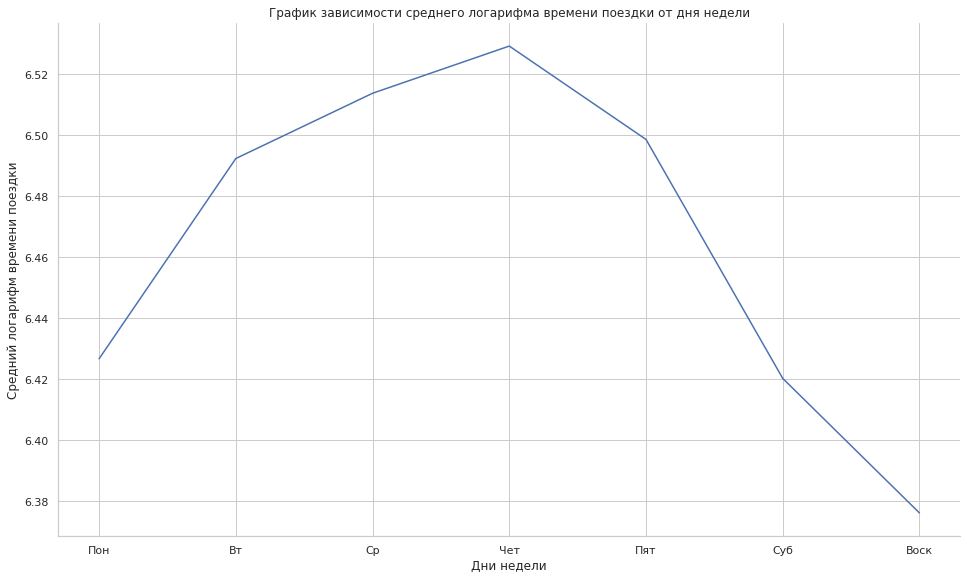

In [243]:
df_train = X_train.merge(y_train, left_index=True, right_index=True)
weekdays = df_train['pickup_datetime'].dt.dayofweek
mean_log_trip_duration_of_weekdays = df_train.groupby([weekdays]).mean()

mapping = {0:'Пон',1:'Вт',2:'Ср',3:'Чет',4:'Пят',5:'Суб', 6:'Воск'}
mean_log_trip_duration_of_weekdays.index = mean_log_trip_duration_of_weekdays.index.map(mapping)

sns.relplot(
    x=mean_log_trip_duration_of_weekdays.index,
    y=mean_log_trip_duration_of_weekdays['log_trip_duration'],
    height=8,
    aspect=1.7,
    kind="line",
    )

plt.title('График зависимости среднего логарифма времени поездки от дня недели')
plt.ylabel('Средний логарифм времени поездки')
plt.xlabel('Дни недели')

plt.show()

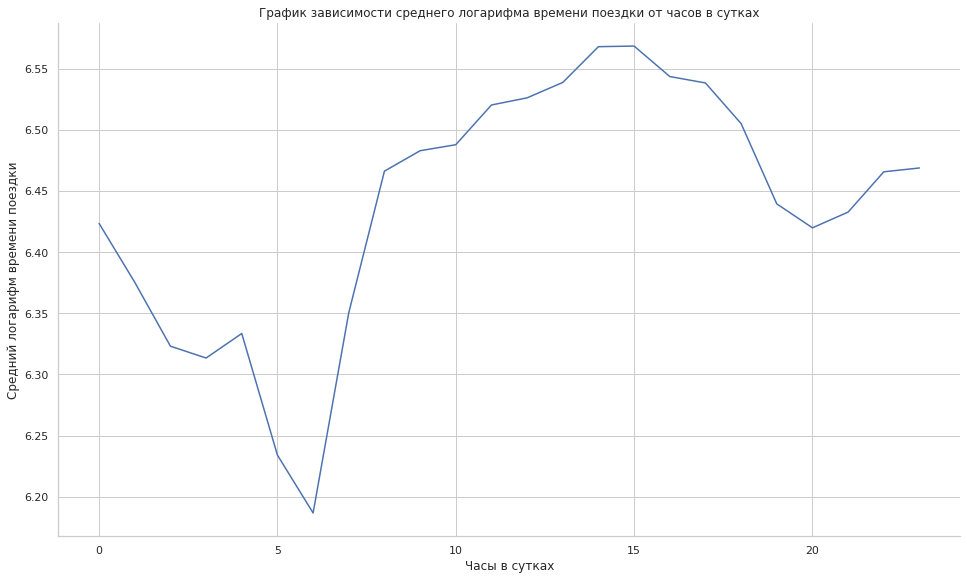

In [244]:
df_train = X_train.merge(y_train, left_index=True, right_index=True)
hours = df_train['pickup_datetime'].dt.hour
mean_log_trip_duration_of_hours = df_train.groupby([hours]).mean()

sns.relplot(
    x=mean_log_trip_duration_of_hours.index,
    y=mean_log_trip_duration_of_hours['log_trip_duration'],
    height=8,
    aspect=1.7,
    kind="line",
    )

plt.title('График зависимости среднего логарифма времени поездки от часов в сутках')
plt.ylabel('Средний логарифм времени поездки')
plt.xlabel('Часы в сутках')

plt.show()

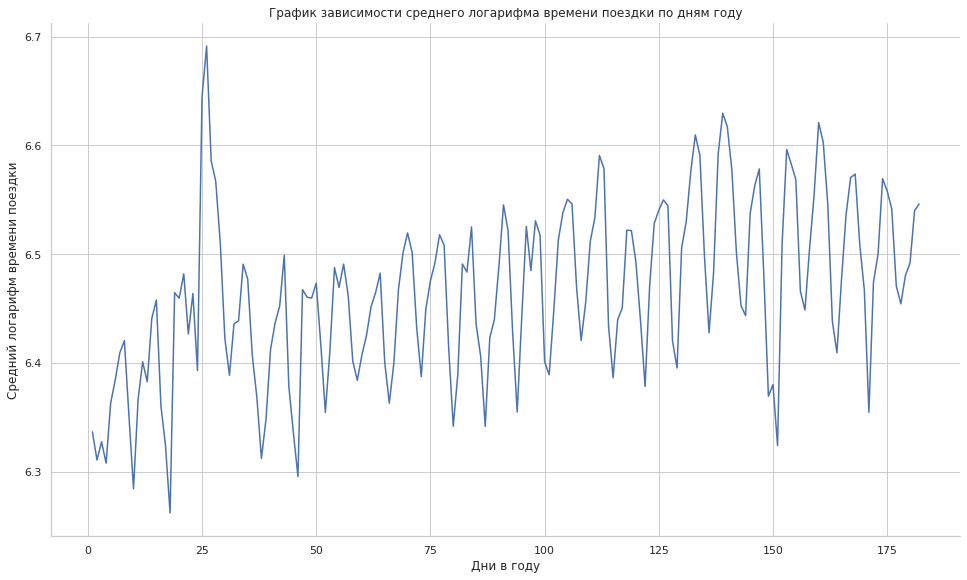

In [245]:
df_train = X_train.merge(y_train, left_index=True, right_index=True)
daysofyear = df_train['pickup_datetime'].dt.dayofyear
mean_log_trip_duration_of_daysofyear = df_train.groupby([daysofyear]).mean()

sns.relplot(
    x=mean_log_trip_duration_of_daysofyear.index,
    y=mean_log_trip_duration_of_daysofyear['log_trip_duration'],
    height=8,
    aspect=1.7,
    kind="line",
    )

# plt.xticks([]) # убрать подпись значений по оси Х
# plt.xlim(0, 49)
plt.title('График зависимости среднего логарифма времени поездки по дням году')
plt.ylabel('Средний логарифм времени поездки')
plt.xlabel('Дни в году')

plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

---
Заметно, что сразу после случившегося снегопада среднее время в поездке резко возросло в ближайшие несколько дней и достигло своего пика 25-26 января

Среднее время поездки 'log_trip_duration' в течении года (в нашем случае полугодия) имеет ростущий тренд.

---


Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [246]:
def abnormal_date_1(df):
    if (df==23)|(df==24):
        return 1
    return 0

def abnormal_date_2(df):
    if df==151:
        return 1
    return 0

In [247]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df.loc[:, 'dayofweek'] = df['pickup_datetime'].dt.dayofweek
df.loc[:, 'months'] = df['pickup_datetime'].dt.month
df.loc[:, 'hours'] = df['pickup_datetime'].dt.hour
df.loc[:, 'dayofyear'] = df['pickup_datetime'].dt.dayofyear
df.loc[:, 'abnormal_date_1'] = df['dayofyear'].apply(abnormal_date_1) # 1 период 23-24 января
df.loc[:, 'abnormal_date_2'] = df['dayofyear'].apply(abnormal_date_2) # 2 период 30 мая


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

---
Из всех представленных признаков, категориальными признаками будем рассматривать - день недели, месяц, аномальный период.

Категориальный признак – это признак, значения которого обозначают принадлежность объекта к какой-то категории. Примеры таких признаков: национальность, гражданство, профессия, должность, идентификационный номер, номер группы студента, тарифный план, издательство, область науки и т.п.

Какой-то разумности в складывании/вычитании:
- вторника со средой, я не вижу
- января с февралем, я не вижу

Опираясь на статью https://habr.com/ru/post/527860/ примем за интервальный (численный) тип данных - день в году и часы.
Хотя, вполне возможно их принять и как категориальные.

---

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [248]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split

X=df.drop('log_trip_duration', 1)
y=df['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [249]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

categorical = list(X_train[['dayofweek', 'months']].columns)
numeric_features = X_train[['hours', 'dayofyear']].columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train.iloc[:, 9:], y_train)
y_pred = model.predict(X_test.iloc[:, 9:])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Constant RMSE = %.4f" % mean_log_trip_duration**0.5)

Test RMSE = 0.7920
Constant RMSE = 0.7958


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [250]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [251]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [252]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

---
Если я правильно понял вопрос, то это скопление поездок в/из 2х аэропортов

---

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [253]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [254]:
df.loc[:, 'distance_haversine'] = haversine_array(
    df['pickup_latitude'].values, 
    df['pickup_longitude'].values, 
    df['dropoff_latitude'].values, 
    df['dropoff_longitude'].values
    )

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [255]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['log_distance_haversine'] = np.log1p(df['distance_haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

Text(0.5, 1.0, 'distance_haversine')

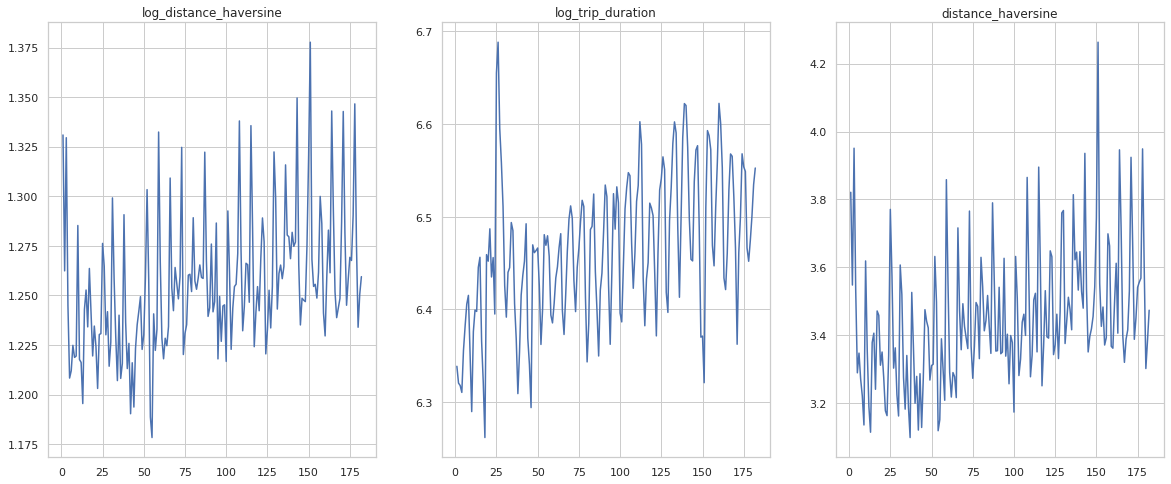

In [256]:
daysofyear = df['pickup_datetime'].dt.dayofyear
mean_log_distance_haversine = df.groupby([daysofyear]).mean()

#1
plt.subplot2grid((1,3), (0,0))
plt.plot(
    mean_log_distance_haversine.index,
    mean_log_distance_haversine['log_distance_haversine'],
    )
plt.title('log_distance_haversine')

#2
plt.subplot2grid((1,3), (0,1))
plt.plot(
    mean_log_distance_haversine.index,
    mean_log_distance_haversine['log_trip_duration'],
    )
plt.title('log_trip_duration')

#3
plt.subplot2grid((1,3), (0,2))
plt.plot(
    mean_log_distance_haversine.index,
    mean_log_distance_haversine['distance_haversine'],
    )
plt.title('distance_haversine')



**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

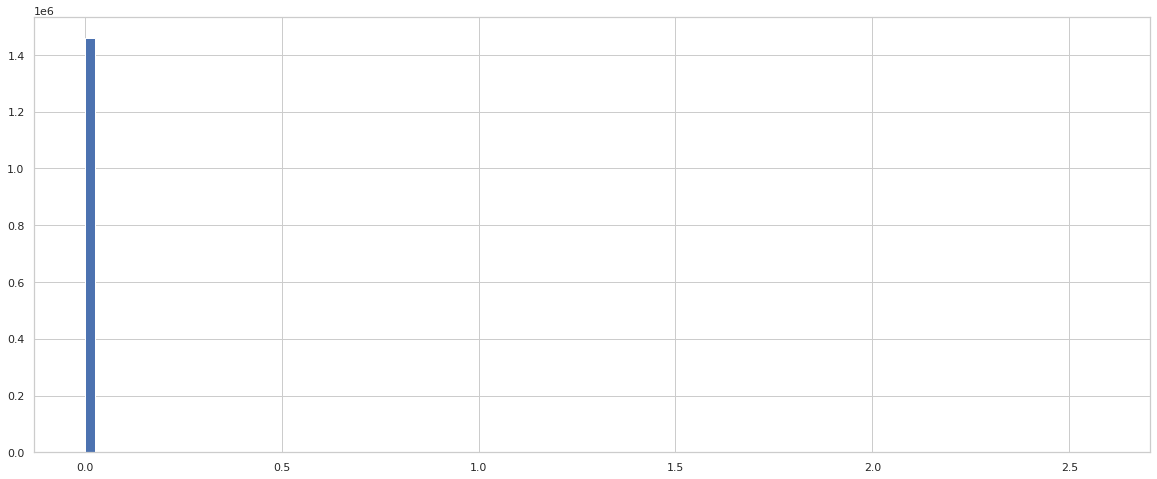

In [257]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['speed'] = df['distance_haversine']/np.expm1(df['log_trip_duration']) # в км/c
df['speed'].hist(bins=100)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [258]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
np.percentile(df['speed'], 99.9)

0.01508388120871655

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff52231b890>]],
      dtype=object)

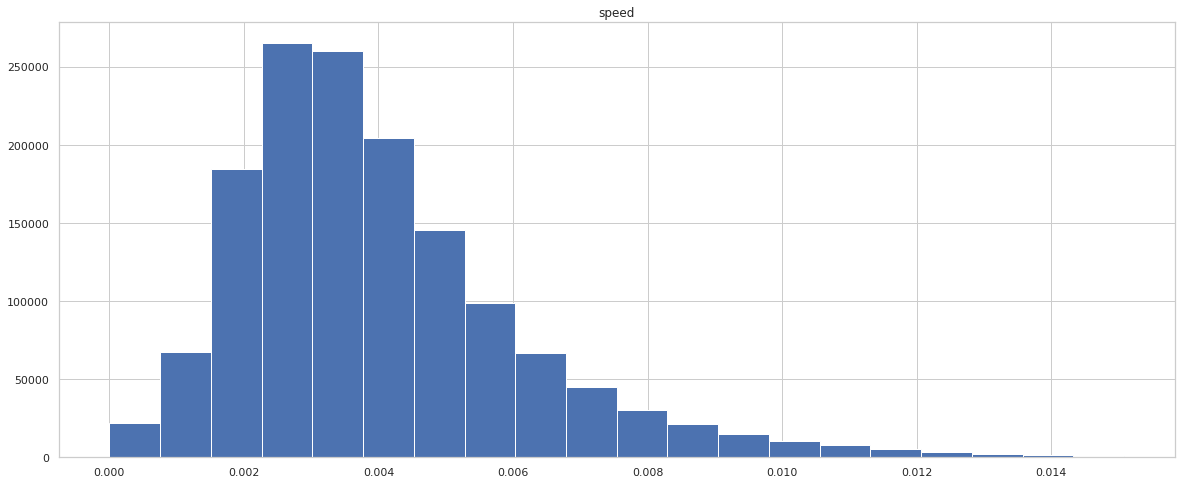

In [259]:
df[df['speed']<np.percentile(df['speed'], 99.9)].hist('speed', bins=20)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

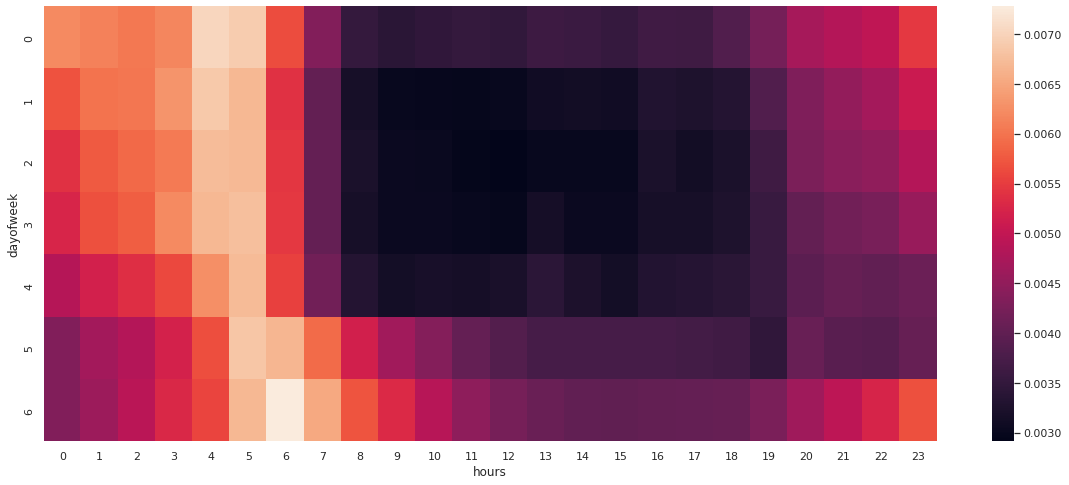

In [260]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df.loc[:, 'dayofweek'] = df['pickup_datetime'].dt.dayofweek
df.loc[:, 'hours'] = df['pickup_datetime'].dt.hour

df_heatmap = df.pivot_table(
                        index='dayofweek', 
                        columns='hours', 
                        values='speed', 
                        aggfunc='mean',
                        )
sns.heatmap(df_heatmap)

plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

---
Это приведет к утечке данных из целевой переменной, и получится переобученная модель

---

In [261]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df.drop('speed', 1, inplace=True)
df.head(0)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dayofweek,months,hours,dayofyear,abnormal_date_1,abnormal_date_2,distance_haversine,log_distance_haversine


**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [262]:
def traffic_jams(h, d):
    # [8:18] часов и [1:4] дни (вторник:пятница)- пробки
    return (h>=8)&(h<=18)&(d>=1)&(d<=4)

def free_road(h, d):
    # [1:5] часов и [0:3] дни (понедельник:четверг), [5:6] часов и [5:6] дни - свободные дороги
    return ((h>=1)&(h<=5)&(d>=0)&(d<=3))|((h>=5)&(h<=6)&(d>=5)&(d<=6))

In [263]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df.loc[:, 'traffic_jams'] = traffic_jams(
    df['hours'].values,
    df['dayofweek'].values
    )
df.loc[:, 'free_road'] = free_road(
    df['hours'].values,
    df['dayofweek'].values
    )
df.replace({True:1, False:0}, inplace=True)

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [264]:
# df_tmp = pd.DataFrame({"pickup_latitude":[40.635, 40.655], "pickup_longitude":[-73.775, -73.795]}) # Kennedy
df_tmp = pd.DataFrame({"pickup_latitude":[40.765, 40.7775], "pickup_longitude":[-73.8615, -73.88]}) # La Guardia
show_circles_on_map(df_tmp, "pickup_latitude", "pickup_longitude", "blue")

In [265]:
def kennedy_start(df):
# Контакты аэропорта John F Kennedy International
# 1995 га площадь
# Широта: 40.633333000000           
# Долгота: -73.783333000000
    if (df['pickup_longitude']<-73.775)&(df['pickup_longitude']>-73.795):
        if (df['pickup_latitude']>40.635)&(df['pickup_latitude']<40.655):
            return 1
    return 0

def la_guardia_start(df):
# Контакты аэропорта La Guardia
# 42 га площадь
# Широта: 40.777250000000
# Долгота: -73.872611000000
    if (df['pickup_longitude']<-73.8615)&(df['pickup_longitude']>-73.88):
        if (df['pickup_latitude']>40.765)&(df['pickup_latitude']<40.7775):
            return 1
    return 0

def kennedy_finish(df):
    if (df['dropoff_longitude']<-73.775)&(df['dropoff_longitude']>-73.795):
        if (df['dropoff_latitude']>40.635)&(df['dropoff_latitude']<40.655):
            return 1
    return 0

def la_guardia_finish(df):
    if (df['dropoff_longitude']<-73.8615)&(df['dropoff_longitude']>-73.88):
        if (df['dropoff_latitude']>40.765)&(df['dropoff_latitude']<40.7775):
            return 1
    return 0

In [266]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# https://v-ipc.ru/guides/coord

df.loc[:,'kennedy_start'] = df.apply(kennedy_start, axis=1)
df.loc[:,'la_guardia_start'] = df.apply(la_guardia_start, axis=1)
df.loc[:,'kennedy_finish'] = df.apply(kennedy_finish, axis=1)
df.loc[:,'la_guardia_finish'] = df.apply(la_guardia_finish, axis=1)

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [267]:
plt.rcParams['figure.figsize']=(10,6)

(31186, 24)

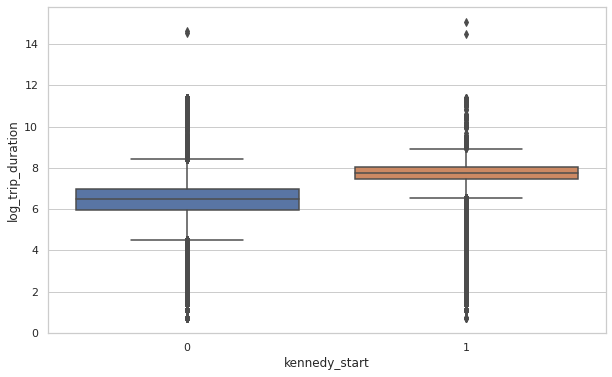

In [268]:
sns.boxplot(y=df['log_trip_duration'], x=df['kennedy_start'])
df[df['kennedy_start']==1].shape

(35604, 24)

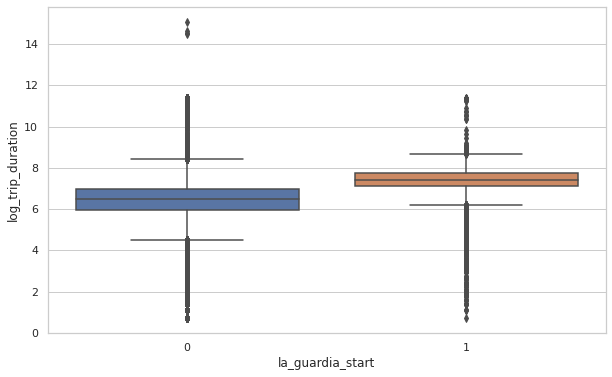

In [269]:
sns.boxplot(y=df['log_trip_duration'], x=df['la_guardia_start'])
df[df['la_guardia_start']==1].shape

(11739, 24)

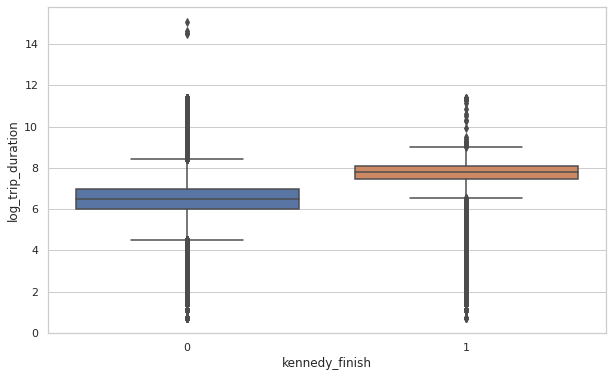

In [270]:
sns.boxplot(y=df['log_trip_duration'], x=df['kennedy_finish'])
df[df['kennedy_finish']==1].shape

(16926, 24)

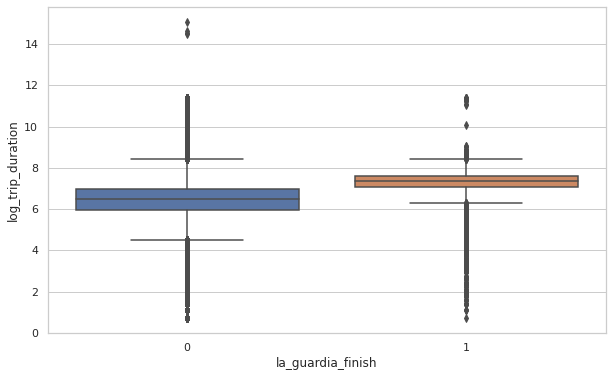

In [271]:
sns.boxplot(y=df['log_trip_duration'], x=df['la_guardia_finish'])
df[df['la_guardia_finish']==1].shape

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

---
Медианное значение log_trip_duration определяемое на признаке отличается от остальной выборки, думаю это можно посчитать положительным для значимого признака. Однако стоит заметить, что разброс значений очень велик, что в свою очередь уменьшит полезность для модели созданных признаков.

---

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [272]:
!pip install ipyleaflet

In [273]:
#     #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# https://prog-help.ru/python/razbienie-oblasti-na-jachejki-i-prisvoenie-metok-s-nachalom-i-koncom/
# https://ru.stackoverflow.com/questions/1161594/%D0%A0%D0%B0%D0%B7%D0%B1%D0%B8%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D0%B8-%D0%BD%D0%B0-%D1%8F%D1%87%D0%B5%D0%B9%D0%BA%D0%B8-%D0%B8-%D0%BF%D1%80%D0%B8%D1%81%D0%B2%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BC%D0%B5%D1%82%D0%BE%D0%BA-%D1%81-%D0%BD%D0%B0%D1%87%D0%B0%D0%BB%D0%BE%D0%BC-%D0%B8-%D0%BA%D0%BE%D0%BD%D1%86%D0%BE%D0%BC
from sklearn.base import BaseEstimator, TransformerMixin
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles, Polygon, CircleMarker, LayerGroup

from scipy.spatial.distance import cdist

COL_NAMES = dict(
    pick_lat="pickup_latitude",
    pick_lon="pickup_longitude",
    drop_lat="dropoff_latitude",
    drop_lon="dropoff_longitude"
)

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, loc, col, row, col_names=COL_NAMES):
        self.location_mh = loc
        self.col = col
        self.row = row
        self.col_names = col_names
        self.pick_lat = col_names["pick_lat"]
        self.pick_lon = col_names["pick_lon"]
        self.drop_lat = col_names["drop_lat"]
        self.drop_lon = col_names["drop_lon"]
        self.lat_min, self.lat_max = loc[:, 0].min(), loc[:, 0].max()
        self.lon_min, self.lon_max = loc[:, 1].min(), loc[:, 1].max()

    def create_box_(self, loc):
        polygon_loc = [
                    [(loc[0] - self.walls[0] / 2), loc[1] - self.walls[1] / 2],
                    [loc[0] + self.walls[0] / 2, loc[1] - self.walls[1] / 2],
                    [loc[0] + self.walls[0] / 2, loc[1] + self.walls[1] / 2],
                    [loc[0] - self.walls[0] / 2, loc[1] + self.walls[1] / 2]
                  ]
        return polygon_loc

    def show_map(self):
        self.walls, self.circles_loc = self._fit()
        _map = Map(center=((self.location_mh[:, 0]).mean(), (self.location_mh[:, 1]).mean()),
                   zoom=11, basemap=basemaps.Esri.NatGeoWorldMap)

        circles = [(CircleMarker(location=(lat, long), fill_color='red',
                                 fill_opacity=1, radius=5, stroke=False)) for lat, long in self.circles_loc]
        polygons = [(Polygon(locations=self.create_box_(loc), fill_opacity=0)) for loc in self.circles_loc]

        circles_layer = LayerGroup(layers=circles)
        polygon_layer = LayerGroup(layers=polygons)

        _map.add_layer(circles_layer)
        _map.add_layer(polygon_layer)

        return _map

    def _fit(self):
        self.walls = [(self.location_mh[:, 0].max() - self.location_mh[:, 0].min()) / self.col, \
              (self.location_mh[:, 1].max() - self.location_mh[:, 1].min()) / self.row]

        self.circles_loc = np.array([(((self.location_mh[:, 0].min() + i * (self.walls[0] / 2))), \
                               (self.location_mh[:, 1].min() + j * (self.walls[1] / 2)) ) \
                            for i in range(1, (self.col) * 2, 2) for j in range(1, (self.row) * 2, 2)])

        return self.walls, self.circles_loc

    def get_sector_idx(self, X):
        _, self.circles_loc = self._fit()
        pickup_idx = cdist(X.loc[:, [self.pick_lat, self.pick_lon]], self.circles_loc).argmin(axis=1)
        dropoff_idx = cdist(X.loc[:, [self.drop_lat, self.drop_lon]], self.circles_loc).argmin(axis=1)
        qry = f"@self.lat_min <= {self.pick_lat} <= @self.lat_max \
               and @self.lon_min <= {self.pick_lon} <= @self.lon_max"
        pickup_valid = X.eval(qry).to_numpy()
        pickup_idx[~pickup_valid] = -1
        qry = f"@self.lat_min <= {self.drop_lat} <= @self.lat_max \
               and @self.lon_min <= {self.drop_lon} <= @self.lon_max"
        dropoff_valid = X.eval(qry).to_numpy()
        dropoff_idx[~dropoff_valid] = -1
        return pickup_idx, dropoff_idx

    def transform(self, X):
        return (X,) + self.get_sector_idx(X)


In [274]:
mh = np.array([
                [40.703314, -74.018608],
                [40.703314, -73.934241],
                [40.791438, -73.934241],
                [40.791438, -74.018608]
               ])

a = MapGridTransformer(mh, 5, 4)
test_cut = a.transform(df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])  
test_cut

(         pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude
 0              40.767937        -73.982155         40.765602         -73.964630
 1              40.738564        -73.980415         40.731152         -73.999481
 2              40.763939        -73.979027         40.710087         -74.005333
 3              40.719971        -74.010040         40.706718         -74.012268
 4              40.793209        -73.973053         40.782520         -73.972923
 ...                  ...               ...               ...                ...
 1458639        40.745522        -73.982201         40.740170         -73.994911
 1458640        40.747379        -74.000946         40.796547         -73.970184
 1458641        40.768799        -73.959129         40.707371         -74.004433
 1458642        40.749062        -73.982079         40.757107         -73.974632
 1458643        40.781750        -73.979538         40.790585         -73.972809
 
 [1458644 rows x 4 columns

In [275]:
df = df.merge(pd.DataFrame({'start_circle':test_cut[1], 'end_circle':test_cut[2]}), left_index=True, right_index=True)
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dayofweek,months,hours,dayofyear,abnormal_date_1,abnormal_date_2,distance_haversine,log_distance_haversine,traffic_jams,free_road,kennedy_start,la_guardia_start,kennedy_finish,la_guardia_finish,start_circle,end_circle
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,0,3,17,74,0,0,1.498521,0.915699,0,0,0,0,0,0,13,14
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,6,6,0,164,0,0,1.805507,1.031584,0,0,0,0,0,0,5,4
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,1,1,11,19,0,0,6.385098,1.999464,1,0,0,0,0,0,13,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,2,4,19,97,0,0,1.485498,0.910473,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,5,3,13,86,0,0,1.188588,0.783257,0,0,0,0,0,0,-1,18


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [276]:
df.drop('distance_haversine',1, inplace=True)

In [277]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split

X=df.drop('log_trip_duration', 1)
y=df['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [278]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
categorical = list(X_train[['dayofweek', 'months', 'start_circle', 'end_circle']].columns)
numeric_features = X_train[['hours', 'dayofyear', 'log_distance_haversine']].columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train.iloc[:, 9:], y_train)
y_pred = model.predict(X_test.iloc[:, 9:])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Constant RMSE = %.4f" % mean_log_trip_duration**0.5)

Test RMSE = 0.5026
Constant RMSE = 0.7958


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

---

vendor_id - возможно есть зависимость/схожесть маршрутов/территорий для одинакового id

passenger_count - возможно есть зависимость в длительности поездки от количества пассажиров

store_and_fwd_flag - возможно такси было в области где нет связи и это даст общность, в купе с другими признаками, для таких поездок

---

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [279]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('vendor_id:', df['vendor_id'].nunique(),',', df['vendor_id'].shape[0])
print('passenger_count:', df['passenger_count'].nunique(),',', df['passenger_count'].shape[0])
print('store_and_fwd_flag:', df['store_and_fwd_flag'].nunique(),',', df['store_and_fwd_flag'].shape[0])

vendor_id: 2 , 1458644
passenger_count: 10 , 1458644
store_and_fwd_flag: 2 , 1458644


In [280]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('vendor_id:', df['vendor_id'].unique(),',', df['vendor_id'].shape[0])
print('passenger_count:', df['passenger_count'].unique(),',', df['passenger_count'].shape[0])
print('store_and_fwd_flag:', df['store_and_fwd_flag'].unique(),',', df['store_and_fwd_flag'].shape[0])

vendor_id: [2 1] , 1458644
passenger_count: [1 6 4 2 3 5 0 7 9 8] , 1458644
store_and_fwd_flag: ['N' 'Y'] , 1458644


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

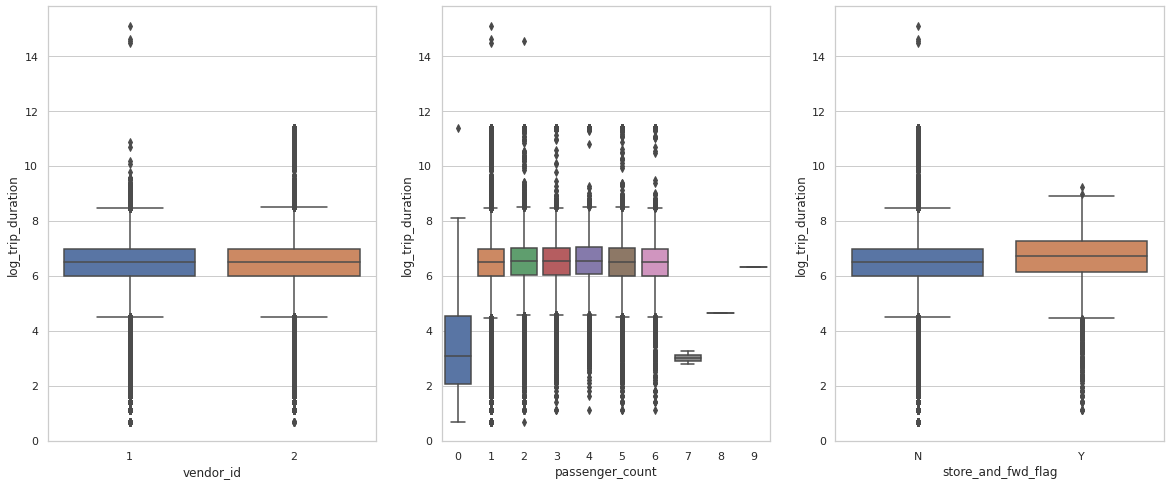

In [281]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# https://python-scripts.com/matplotlib#5
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))

sns.boxplot(y=df['log_trip_duration'], x=df['vendor_id'], ax=ax1)

sns.boxplot(y=df['log_trip_duration'], x=df['passenger_count'], ax=ax2)

sns.boxplot(y=df['log_trip_duration'], x=df['store_and_fwd_flag'], ax=ax3)

plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [282]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['vendor_id'] = df['vendor_id'].replace({2:0})
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace({'N':0,'Y':1})
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dayofweek,months,hours,dayofyear,abnormal_date_1,abnormal_date_2,log_distance_haversine,traffic_jams,free_road,kennedy_start,la_guardia_start,kennedy_finish,la_guardia_finish,start_circle,end_circle
0,id2875421,0,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,0,6.122493,0,3,17,74,0,0,0.915699,0,0,0,0,0,0,13,14
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,0,6.498282,6,6,0,164,0,0,1.031584,0,0,0,0,0,0,5,4
2,id3858529,0,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661527,1,1,11,19,0,0,1.999464,1,0,0,0,0,0,13,0
3,id3504673,0,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,0,6.063785,2,4,19,97,0,0,0.910473,0,0,0,0,0,0,0,0
4,id2181028,0,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,0,6.077642,5,3,13,86,0,0,0.783257,0,0,0,0,0,0,-1,18


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

---

Полагаю, что нет. Признаки очень схожи и выделить только значения выбросы

---

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [283]:
df.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,dayofweek,months,hours,dayofyear,abnormal_date_1,abnormal_date_2,log_distance_haversine,traffic_jams,free_road,kennedy_start,la_guardia_start,kennedy_finish,la_guardia_finish,start_circle,end_circle
0,id2875421,0,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,0,6.122493,0,3,17,74,0,0,0.915699,0,0,0,0,0,0,13,14


In [284]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split

X=df.drop('log_trip_duration', 1)
y=df['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [285]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
categorical = list(X_train[['dayofweek', 'months', 'start_circle', 'end_circle', 'passenger_count']].columns)
numeric_features = X_train[['hours', 'dayofyear', 'log_distance_haversine']].columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

learn_column = X_train.iloc[:, 8:].columns.append(df[['vendor_id', 'passenger_count']].columns)

model = pipeline.fit(X_train.loc[:, learn_column], y_train)
y_pred = model.predict(X_test.loc[:, learn_column])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Constant RMSE = %.4f" % mean_log_trip_duration**0.5)

Test RMSE = 0.5024
Constant RMSE = 0.7958


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

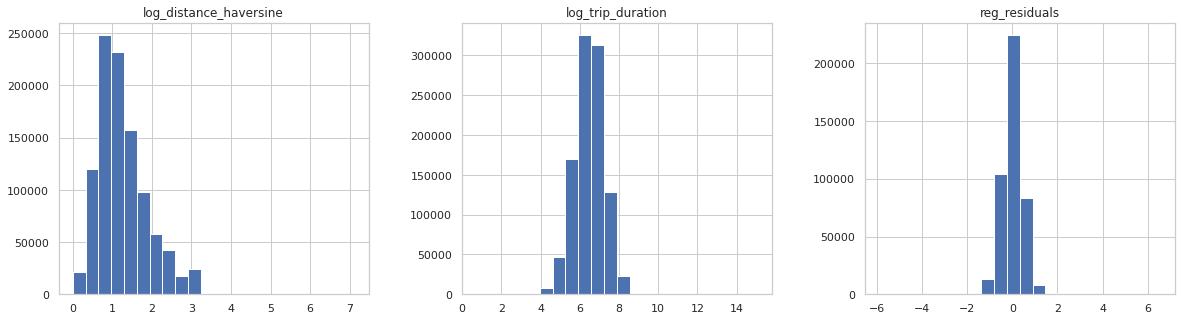

In [286]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
fig,(ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20, 5))
# ax1
X_train.hist('log_distance_haversine', bins=22, ax=ax1)
# ax2
y_train.hist(bins=22, ax=ax2)
ax2.set_title('log_trip_duration')
# ax3
reg_residuals = pd.Series(np.array(y_test)-y_pred, name='reg_residuals')
reg_residuals.hist(bins=22, ax=ax3)
ax3.set_title('reg_residuals')

plt.show()

In [287]:
X_train.shape

(1021050, 24)

In [288]:
df_train = pd.concat([X_train,y_train, reg_residuals], axis=1)
df_train = df_train.loc[df_train['log_distance_haversine']<4] # расстояние
df_train = df_train.loc[df_train['log_trip_duration']>2] # время
df_train = df_train.loc[(df_train['reg_residuals']<2)&(df_train['reg_residuals']>-2)] #остатки


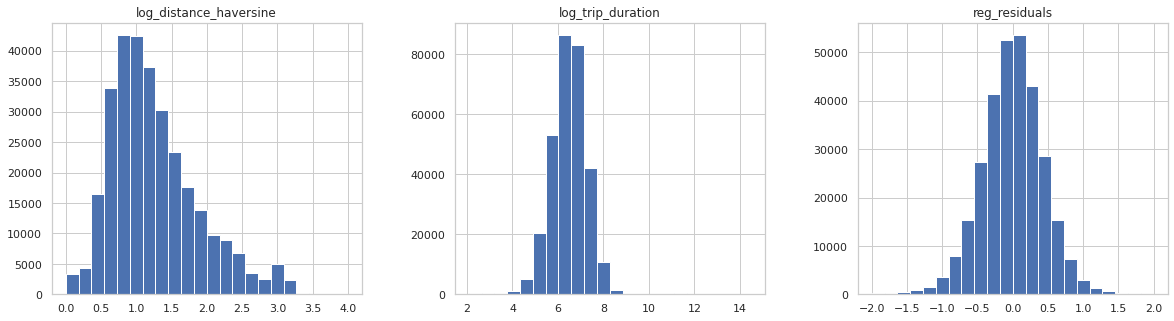

(304798, 26)

In [289]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
fig,(ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20, 5))
# ax1
df_train.hist('log_distance_haversine', bins=22, ax=ax1)
# ax2
df_train.hist('log_trip_duration', bins=22, ax=ax2)
# ax3
df_train.hist('reg_residuals', bins=22, ax=ax3)

plt.show()
df_train.shape

In [290]:
X_train=df_train.drop(['log_trip_duration', 'reg_residuals'], 1)
y_train=df_train['log_trip_duration']
X_train.shape
# Количество данных на train уменьшилось в 3 раза

(304798, 24)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [291]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Попробуем объединить в одну категорию старт из аэропортов и финиш в аэропорты
print(X_train[X_train['kennedy_start']==1].shape)
print(X_train[X_train['la_guardia_start']==1].shape)

print(X_train[X_train['kennedy_finish']==1].shape)
print(X_train[X_train['la_guardia_finish']==1].shape)
# Как видно категория малочисленная/редко встречающаяся

(6347, 24)
(7395, 24)
(2457, 24)
(3567, 24)


In [292]:
# https://coderoad.ru/53779986/%D0%94%D0%B8%D0%BD%D0%B0%D0%BC%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8-%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D1%8F%D1%82%D1%8C-%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5-%D0%B8%D0%B7-%D1%84%D0%BE%D1%80%D0%BC%D1%83%D0%BB%D1%8B-%D0%B2-pandas
# https://coderoad.ru/21415661/%D0%9B%D0%BE%D0%B3%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5-%D0%BE%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80%D1%8B-%D0%B4%D0%BB%D1%8F-%D0%B1%D1%83%D0%BB%D0%B5%D0%B2%D0%BE%D0%B9-%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D0%B0%D1%86%D0%B8%D0%B8-%D0%B2-Pandas
cols = ["kennedy_start","la_guardia_start","kennedy_finish", 'la_guardia_finish']
X_train = X_train.eval("airpots = 0+(0!=(kennedy_start + la_guardia_start + kennedy_finish + la_guardia_finish))").drop(columns=cols)
X_test = X_test.eval("airpots = 0+(0!=(kennedy_start + la_guardia_start + kennedy_finish + la_guardia_finish))").drop(columns=cols)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [293]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
categorical = list(X_train[['dayofweek', 'months', 'start_circle', 'end_circle', 'passenger_count']].columns)
numeric_features = X_train[['hours', 'dayofyear', 'log_distance_haversine']].columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline_ridge = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

learn_column = X_train.iloc[:, 8:].columns.append(df[['vendor_id', 'passenger_count']].columns)

model_ridge = pipeline_ridge.fit(X_train.loc[:, learn_column], y_train)
y_pred = model_ridge.predict(X_test.loc[:, learn_column])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Constant RMSE = %.4f" % mean_log_trip_duration**0.5)

Test RMSE = 0.5025
Constant RMSE = 0.7958


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [294]:
print("Size before OneHot:", X_train.loc[:, learn_column].shape)
print("Size after OneHot:", column_transformer.transform(X_train.loc[:, learn_column]).shape)

Size before OneHot: (304798, 15)
Size after OneHot: (304798, 67)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [295]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Lasso

categorical = list(X_train[['dayofweek', 'months', 'start_circle', 'end_circle', 'passenger_count']].columns)
numeric_features = X_train[['hours', 'dayofyear', 'log_distance_haversine']].columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

learn_column = X_train.iloc[:, 8:].columns.append(df[['vendor_id', 'passenger_count']].columns)

model_lasso = pipeline_lasso.fit(X_train.loc[:, learn_column], y_train)
y_pred = model_lasso.predict(X_test.loc[:, learn_column])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Constant RMSE = %.4f" % mean_log_trip_duration**0.5)

Test RMSE = 0.7950
Constant RMSE = 0.7958


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [296]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Best alpha = 26.3665


Text(0, 0.5, 'CV score')

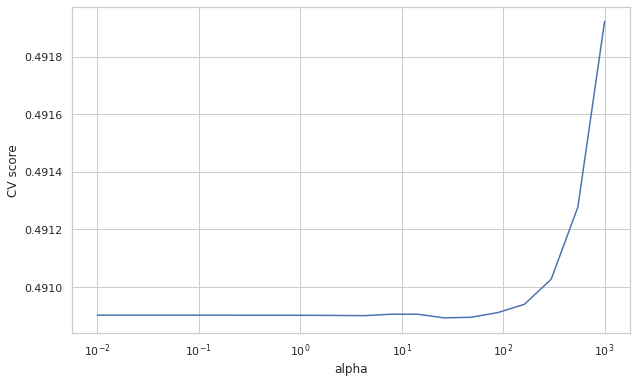

In [297]:
# https://scikit-learn.org/stable/modules/compose.html#pipeline
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(pipeline_ridge, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", n_jobs=-1)
searcher.fit(X_val.loc[:, learn_column], y_val)

best_alpha_ridge = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha_ridge)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Best alpha = 0.000100


Text(0, 0.5, 'CV score')

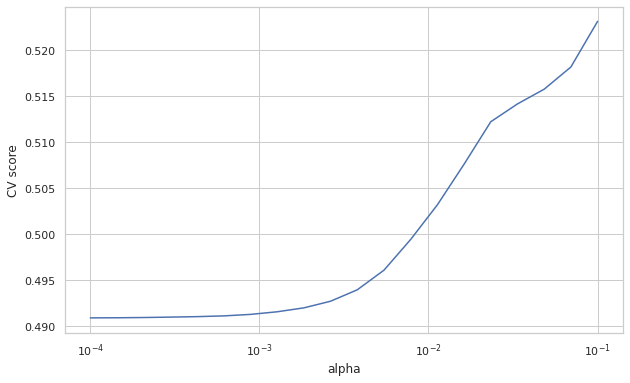

In [298]:
alphas = np.logspace(-4, -1, 20)
searcher = GridSearchCV(pipeline_lasso, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", n_jobs=-1)
searcher.fit(X_val.loc[:, learn_column], y_val)

best_alpha_lasso = searcher.best_params_["regression__alpha"]
print("Best alpha = %.6f" % best_alpha_lasso)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

---

В нашем подборе лучший параметр уже убирает 59 признаков, что больше половины. Используем его для определения изменения качества модели.

Попробовал посчитать для другого диапозона alpha, половину параметров убирается при значении alpha=0.0008. Попробую оценить с этим значением.

---

In [299]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
alphas = np.logspace(-4, -1, 20)

In [300]:
categorical = list(X_train[['dayofweek', 'months', 'start_circle', 'end_circle', 'passenger_count']].columns)
numeric_features = X_train[['hours', 'dayofyear', 'log_distance_haversine']].columns
learn_column = X_train.iloc[:, 8:].columns.append(df[['vendor_id', 'passenger_count']].columns)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_zeros = []
for el in alphas:
    pipeline_lasso = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Lasso(el))
    ])
    model_lasso = pipeline_lasso.fit(X_train.loc[:, learn_column], y_train)
    lasso_zeros.append(np.sum(pipeline_lasso.steps[-1][-1].coef_ == 0))


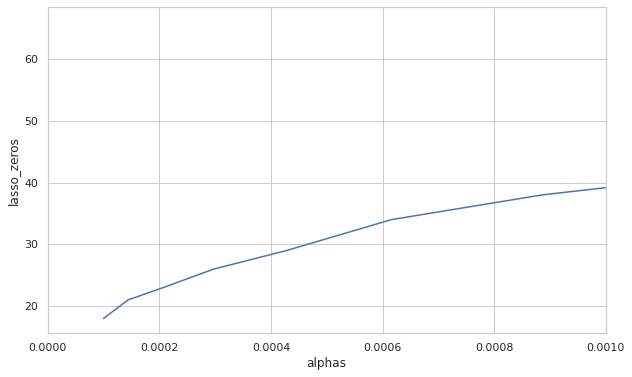

In [301]:
plt.plot(alphas, lasso_zeros)
plt.xlim(0, 0.001)
plt.ylabel('lasso_zeros')
plt.xlabel('alphas')
plt.show()

In [302]:
# Всего признаков 67, уменьшаем в 2 раза до 33 (0.5025 при альфа 0)
categorical = list(X_train[['dayofweek', 'months', 'start_circle', 'end_circle', 'passenger_count']].columns)
numeric_features = X_train[['hours', 'dayofyear', 'log_distance_haversine']].columns
learn_column = X_train.iloc[:, 8:].columns.append(df[['vendor_id', 'passenger_count']].columns)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(0.0008))
])

model_lasso = pipeline_lasso.fit(X_train.loc[:, learn_column], y_train)
y_pred = model_lasso.predict(X_test.loc[:, learn_column])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Constant RMSE = %.4f" % mean_log_trip_duration**0.5)

Test RMSE = 0.5031
Constant RMSE = 0.7958


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

---

С помощью него можно выделить частые маршруты и расставить коэффициенты по частототе маршрутов и завсимость от других признаков.

Признак определяет самые частые маршруты по нашей сетке, а в ранее заданных признаках все переезды были равны.

---

In [303]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
frequent_route_train = X_train.value_counts(['start_circle', 'end_circle'], ascending=False)
frequent_route_test = X_test.value_counts(['start_circle', 'end_circle'], ascending=False)

# Если в индексе встретится -1, то его в расчет не включаем и ставим -1
frequent_route_train = pd.DataFrame(frequent_route_train).reset_index()
frequent_route_train.rename(columns={0:'frequent_route'}, inplace=True)
indx_freq_rout = frequent_route_train[((frequent_route_train['start_circle']!=-1)&(frequent_route_train['end_circle']!=-1))].iloc[0:100].index
frequent_route_train.loc[indx_freq_rout, 'freq_rout'] = np.arange(0,100)
frequent_route_train.fillna(-1, inplace=True)
frequent_route_train.drop('frequent_route', 1, inplace=True)

frequent_route_test = pd.DataFrame(frequent_route_test).reset_index()
frequent_route_test.rename(columns={0:'frequent_route'}, inplace=True)
indx_freq_rout = frequent_route_test[((frequent_route_test['start_circle']!=-1)&(frequent_route_test['end_circle']!=-1))].iloc[0:100].index
frequent_route_test.loc[indx_freq_rout, 'freq_rout'] = np.arange(0,100)
frequent_route_test.fillna(-1, inplace=True)
frequent_route_test.drop('frequent_route', 1, inplace=True)


In [304]:
X_train = X_train.merge(frequent_route_train, how='left', left_on=['start_circle', 'end_circle'], right_on=['start_circle', 'end_circle'])
X_test = X_test.merge(frequent_route_test, how='left', left_on=['start_circle', 'end_circle'], right_on=['start_circle', 'end_circle'])

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [305]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
categorical = list(X_train[['dayofweek', 'months', 'start_circle', 'end_circle', 'passenger_count', 'freq_rout']].columns)
numeric_features = X_train[['hours', 'dayofyear', 'log_distance_haversine']].columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline_ridge = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

learn_column = X_train.iloc[:, 8:].columns.append(df[['vendor_id', 'passenger_count']].columns)

model_ridge = pipeline_ridge.fit(X_train.loc[:, learn_column], y_train)
y_pred = model_ridge.predict(X_test.loc[:, learn_column])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Constant RMSE = %.4f" % mean_log_trip_duration**0.5)

Test RMSE = 0.5091
Constant RMSE = 0.7958


In [306]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('test.csv')
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [307]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [308]:
def abnormal_date_1(df):
    if (df==23)|(df==24):
        return 1
    return 0

def abnormal_date_2(df):
    if df==151:
        return 1
    return 0

In [309]:
df.loc[:, 'dayofweek'] = df['pickup_datetime'].dt.dayofweek
df.loc[:, 'months'] = df['pickup_datetime'].dt.month
df.loc[:, 'hours'] = df['pickup_datetime'].dt.hour
df.loc[:, 'dayofyear'] = df['pickup_datetime'].dt.dayofyear
df.loc[:, 'abnormal_date_1'] = df['dayofyear'].apply(abnormal_date_1) # 1 период 23-24 января
df.loc[:, 'abnormal_date_2'] = df['dayofyear'].apply(abnormal_date_2) # 2 период 30 мая

In [310]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [311]:
df.loc[:, 'distance_haversine'] = haversine_array(
    df['pickup_latitude'].values, 
    df['pickup_longitude'].values, 
    df['dropoff_latitude'].values, 
    df['dropoff_longitude'].values
    )

In [312]:
df['log_distance_haversine'] = np.log1p(df['distance_haversine'])

In [313]:
def traffic_jams(h, d):
    # [8:18] часов и [1:4] дни (вторник:пятница)- пробки
    return (h>=8)&(h<=18)&(d>=1)&(d<=4)

def free_road(h, d):
    # [1:5] часов и [0:3] дни (понедельник:четверг), [5:6] часов и [5:6] дни - свободные дороги
    return ((h>=1)&(h<=5)&(d>=0)&(d<=3))|((h>=5)&(h<=6)&(d>=5)&(d<=6))

In [314]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df.loc[:, 'traffic_jams'] = traffic_jams(
    df['hours'].values,
    df['dayofweek'].values
    )
df.loc[:, 'free_road'] = free_road(
    df['hours'].values,
    df['dayofweek'].values
    )
df.replace({True:1, False:0}, inplace=True)

In [315]:
def kennedy_start(df):
# Контакты аэропорта John F Kennedy International
# 1995 га площадь
# Широта: 40.633333000000           
# Долгота: -73.783333000000
    if (df['pickup_longitude']<-73.775)&(df['pickup_longitude']>-73.795):
        if (df['pickup_latitude']>40.635)&(df['pickup_latitude']<40.655):
            return 1
    return 0

def la_guardia_start(df):
# Контакты аэропорта La Guardia
# 42 га площадь
# Широта: 40.777250000000
# Долгота: -73.872611000000
    if (df['pickup_longitude']<-73.8615)&(df['pickup_longitude']>-73.88):
        if (df['pickup_latitude']>40.765)&(df['pickup_latitude']<40.7775):
            return 1
    return 0

def kennedy_finish(df):
    if (df['dropoff_longitude']<-73.775)&(df['dropoff_longitude']>-73.795):
        if (df['dropoff_latitude']>40.635)&(df['dropoff_latitude']<40.655):
            return 1
    return 0

def la_guardia_finish(df):
    if (df['dropoff_longitude']<-73.8615)&(df['dropoff_longitude']>-73.88):
        if (df['dropoff_latitude']>40.765)&(df['dropoff_latitude']<40.7775):
            return 1
    return 0

In [316]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# https://v-ipc.ru/guides/coord

df.loc[:,'kennedy_start'] = df.apply(kennedy_start, axis=1)
df.loc[:,'la_guardia_start'] = df.apply(la_guardia_start, axis=1)
df.loc[:,'kennedy_finish'] = df.apply(kennedy_finish, axis=1)
df.loc[:,'la_guardia_finish'] = df.apply(la_guardia_finish, axis=1)

In [317]:
!pip install ipyleaflet

In [318]:
#     #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# https://prog-help.ru/python/razbienie-oblasti-na-jachejki-i-prisvoenie-metok-s-nachalom-i-koncom/
# https://ru.stackoverflow.com/questions/1161594/%D0%A0%D0%B0%D0%B7%D0%B1%D0%B8%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D0%B8-%D0%BD%D0%B0-%D1%8F%D1%87%D0%B5%D0%B9%D0%BA%D0%B8-%D0%B8-%D0%BF%D1%80%D0%B8%D1%81%D0%B2%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BC%D0%B5%D1%82%D0%BE%D0%BA-%D1%81-%D0%BD%D0%B0%D1%87%D0%B0%D0%BB%D0%BE%D0%BC-%D0%B8-%D0%BA%D0%BE%D0%BD%D1%86%D0%BE%D0%BC
from sklearn.base import BaseEstimator, TransformerMixin
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles, Polygon, CircleMarker, LayerGroup

from scipy.spatial.distance import cdist

COL_NAMES = dict(
    pick_lat="pickup_latitude",
    pick_lon="pickup_longitude",
    drop_lat="dropoff_latitude",
    drop_lon="dropoff_longitude"
)

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, loc, col, row, col_names=COL_NAMES):
        self.location_mh = loc
        self.col = col
        self.row = row
        self.col_names = col_names
        self.pick_lat = col_names["pick_lat"]
        self.pick_lon = col_names["pick_lon"]
        self.drop_lat = col_names["drop_lat"]
        self.drop_lon = col_names["drop_lon"]
        self.lat_min, self.lat_max = loc[:, 0].min(), loc[:, 0].max()
        self.lon_min, self.lon_max = loc[:, 1].min(), loc[:, 1].max()

    def create_box_(self, loc):
        polygon_loc = [
                    [(loc[0] - self.walls[0] / 2), loc[1] - self.walls[1] / 2],
                    [loc[0] + self.walls[0] / 2, loc[1] - self.walls[1] / 2],
                    [loc[0] + self.walls[0] / 2, loc[1] + self.walls[1] / 2],
                    [loc[0] - self.walls[0] / 2, loc[1] + self.walls[1] / 2]
                  ]
        return polygon_loc

    def show_map(self):
        self.walls, self.circles_loc = self._fit()
        _map = Map(center=((self.location_mh[:, 0]).mean(), (self.location_mh[:, 1]).mean()),
                   zoom=11, basemap=basemaps.Esri.NatGeoWorldMap)

        circles = [(CircleMarker(location=(lat, long), fill_color='red',
                                 fill_opacity=1, radius=5, stroke=False)) for lat, long in self.circles_loc]
        polygons = [(Polygon(locations=self.create_box_(loc), fill_opacity=0)) for loc in self.circles_loc]

        circles_layer = LayerGroup(layers=circles)
        polygon_layer = LayerGroup(layers=polygons)

        _map.add_layer(circles_layer)
        _map.add_layer(polygon_layer)

        return _map

    def _fit(self):
        self.walls = [(self.location_mh[:, 0].max() - self.location_mh[:, 0].min()) / self.col, \
              (self.location_mh[:, 1].max() - self.location_mh[:, 1].min()) / self.row]

        self.circles_loc = np.array([(((self.location_mh[:, 0].min() + i * (self.walls[0] / 2))), \
                               (self.location_mh[:, 1].min() + j * (self.walls[1] / 2)) ) \
                            for i in range(1, (self.col) * 2, 2) for j in range(1, (self.row) * 2, 2)])

        return self.walls, self.circles_loc

    def get_sector_idx(self, X):
        _, self.circles_loc = self._fit()
        pickup_idx = cdist(X.loc[:, [self.pick_lat, self.pick_lon]], self.circles_loc).argmin(axis=1)
        dropoff_idx = cdist(X.loc[:, [self.drop_lat, self.drop_lon]], self.circles_loc).argmin(axis=1)
        qry = f"@self.lat_min <= {self.pick_lat} <= @self.lat_max \
               and @self.lon_min <= {self.pick_lon} <= @self.lon_max"
        pickup_valid = X.eval(qry).to_numpy()
        pickup_idx[~pickup_valid] = -1
        qry = f"@self.lat_min <= {self.drop_lat} <= @self.lat_max \
               and @self.lon_min <= {self.drop_lon} <= @self.lon_max"
        dropoff_valid = X.eval(qry).to_numpy()
        dropoff_idx[~dropoff_valid] = -1
        return pickup_idx, dropoff_idx

    def transform(self, X):
        return (X,) + self.get_sector_idx(X)

In [319]:
mh = np.array([
                [40.703314, -74.018608],
                [40.703314, -73.934241],
                [40.791438, -73.934241],
                [40.791438, -74.018608]
               ])

a = MapGridTransformer(mh, 5, 4)
test_cut = a.transform(df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])  
test_cut

(        pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude
 0             40.732029        -73.988129         40.756680         -73.990173
 1             40.679993        -73.964203         40.655403         -73.959808
 2             40.737583        -73.997437         40.729523         -73.986160
 3             40.771900        -73.956070         40.730469         -73.986427
 4             40.761475        -73.970215         40.755890         -73.961510
 ...                 ...               ...               ...                ...
 625129        40.725105        -74.003464         40.733643         -74.001251
 625130        40.743782        -74.006363         40.782467         -73.953407
 625131        40.759865        -73.972267         40.748665         -73.876602
 625132        40.733562        -73.976501         40.891788         -73.854263
 625133        40.716881        -73.981850         40.769379         -73.969330
 
 [625134 rows x 4 columns],
 array([ 5

In [320]:
df = df.merge(pd.DataFrame({'start_circle':test_cut[1], 'end_circle':test_cut[2]}), left_index=True, right_index=True)
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofweek,months,hours,dayofyear,abnormal_date_1,abnormal_date_2,distance_haversine,log_distance_haversine,traffic_jams,free_road,kennedy_start,la_guardia_start,kennedy_finish,la_guardia_finish,start_circle,end_circle
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,3,6,23,182,0,0,2.746426,1.320802,0,0,0,0,0,0,5,13
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,3,6,23,182,0,0,2.759239,1.324217,0,0,0,0,0,0,-1,-1
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,3,6,23,182,0,0,1.306155,0.835582,0,0,0,0,0,0,5,5
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,3,6,23,182,0,0,5.269088,1.835631,0,0,0,0,0,0,14,5
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,3,6,23,182,0,0,0.960842,0.673374,0,0,0,0,0,0,14,10


In [321]:
df.drop('distance_haversine',1, inplace=True)

In [322]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['vendor_id'] = df['vendor_id'].replace({2:0})
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace({'N':0,'Y':1})
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofweek,months,hours,dayofyear,abnormal_date_1,abnormal_date_2,log_distance_haversine,traffic_jams,free_road,kennedy_start,la_guardia_start,kennedy_finish,la_guardia_finish,start_circle,end_circle
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,3,6,23,182,0,0,1.320802,0,0,0,0,0,0,5,13
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,3,6,23,182,0,0,1.324217,0,0,0,0,0,0,-1,-1
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,3,6,23,182,0,0,0.835582,0,0,0,0,0,0,5,5
3,id2150126,0,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,3,6,23,182,0,0,1.835631,0,0,0,0,0,0,14,5
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,3,6,23,182,0,0,0.673374,0,0,0,0,0,0,14,10


In [323]:
cols = ["kennedy_start","la_guardia_start","kennedy_finish", 'la_guardia_finish']
df = df.eval("airpots = 0+(0!=(kennedy_start + la_guardia_start + kennedy_finish + la_guardia_finish))").drop(columns=cols)

In [324]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
frequent_route_train = df.value_counts(['start_circle', 'end_circle'], ascending=False)


# Если в индексе встретится -1, то его в расчет не включаем и ставим -1
frequent_route_train = pd.DataFrame(frequent_route_train).reset_index()
frequent_route_train.rename(columns={0:'frequent_route'}, inplace=True)
indx_freq_rout = frequent_route_train[((frequent_route_train['start_circle']!=-1)&(frequent_route_train['end_circle']!=-1))].iloc[0:100].index
frequent_route_train.loc[indx_freq_rout, 'freq_rout'] = np.arange(0,100)
frequent_route_train.fillna(-1, inplace=True)
frequent_route_train.drop('frequent_route', 1, inplace=True)


In [325]:
df = df.merge(frequent_route_train, how='left', left_on=['start_circle', 'end_circle'], right_on=['start_circle', 'end_circle'])

In [326]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofweek,months,hours,dayofyear,abnormal_date_1,abnormal_date_2,log_distance_haversine,traffic_jams,free_road,start_circle,end_circle,airpots,freq_rout
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,3,6,23,182,0,0,1.320802,0,0,5,13,0,43.0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,3,6,23,182,0,0,1.324217,0,0,-1,-1,0,-1.0
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,3,6,23,182,0,0,0.835582,0,0,5,5,0,7.0
3,id2150126,0,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,3,6,23,182,0,0,1.835631,0,0,14,5,0,37.0
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,3,6,23,182,0,0,0.673374,0,0,14,10,0,22.0


In [328]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
learn_column = X_train.iloc[:, 8:].columns.append(df[['vendor_id', 'passenger_count']].columns)

y_pred = model_ridge.predict(df.loc[:, learn_column])

In [336]:
solution = pd.concat([pd.DataFrame(df['id']), pd.DataFrame(y_pred, columns=['trip_duration'])], axis=1) 
solution.to_csv('solution.csv', index=False)

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [337]:
# #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# def dummy_manhattan_distance_big_angle(lat1, lng1, lat2, lng2, angle_deg = 29):
#     a = haversine_array(lat1, lng1, lat1, lng2)
#     c = haversine_array(lat1, lng1, lat2, lng2)

#     a_1 = np.sin(np.arccos(a/c)- np.radians(angle_deg))*c
#     b_1 = np.cos(np.arccos(a/c)- np.radians(angle_deg))*c
#     return a_1 + b_1

# def dummy_manhattan_distance_small_angle(lat1, lng1, lat2, lng2, angle_deg = 29):
#     a = haversine_array(lat1, lng1, lat1, lng2)
#     c = haversine_array(lat1, lng1, lat2, lng2)

#     a_1 = np.sin(np.radians(angle_deg)-np.arccos(a/c))*c
#     b_1 = np.cos(np.radians(angle_deg)-np.arccos(a/c))*c
#     return a_1 + b_1


In [338]:
# # Под углом 29 градусов к меридиану
# # https://ru.wikipedia.org/wiki/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%BF%D0%BB%D0%B0%D0%BD_%D0%9C%D0%B0%D0%BD%D1%85%D1%8D%D1%82%D1%82%D0%B5%D0%BD%D0%B0

# angle_deg = 29

# big_angle = X_train[np.arccos(haversine_array(X_train['pickup_latitude'].values,
#                                   X_train['pickup_longitude'].values, 
#                                   X_train['pickup_latitude'].values,
#                                   X_train['dropoff_longitude'].values)
#                 /haversine_array(X_train['pickup_latitude'].values,
#                                 X_train['pickup_longitude'].values,
#                                 X_train['dropoff_latitude'].values,
#                                 X_train['dropoff_longitude'].values)) >= np.radians(angle_deg)]

# small_angle = X_train[np.arccos(haversine_array(X_train['pickup_latitude'].values,
#                                   X_train['pickup_longitude'].values, 
#                                   X_train['pickup_latitude'].values,
#                                   X_train['dropoff_longitude'].values)
#                 /haversine_array(X_train['pickup_latitude'].values,
#                                 X_train['pickup_longitude'].values,
#                                 X_train['dropoff_latitude'].values,
#                                 X_train['dropoff_longitude'].values)) < np.radians(angle_deg)]


# X_train[np.arccos(haversine_array(X_train['pickup_latitude'].values,
#                                   X_train['pickup_longitude'].values, 
#                                   X_train['pickup_latitude'].values,
#                                   X_train['dropoff_longitude'].values)
#                 /haversine_array(X_train['pickup_latitude'].values,
#                                 X_train['pickup_longitude'].values,
#                                 X_train['dropoff_latitude'].values,
#                                 X_train['dropoff_longitude'].values)) >= np.radians(angle_deg)]\
# .loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance_big_angle(big_angle['pickup_latitude'].values,
#                                                                big_angle['pickup_longitude'].values,
#                                                                big_angle['dropoff_latitude'].values,
#                                                                big_angle['dropoff_longitude'].values)

# X_train[np.arccos(haversine_array(X_train['pickup_latitude'].values,
#                                   X_train['pickup_longitude'].values, 
#                                   X_train['pickup_latitude'].values,
#                                   X_train['dropoff_longitude'].values)
#                 /haversine_array(X_train['pickup_latitude'].values,
#                                 X_train['pickup_longitude'].values,
#                                 X_train['dropoff_latitude'].values,
#                                 X_train['dropoff_longitude'].values)) < np.radians(angle_deg)]\
# .loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance_small_angle(small_angle['pickup_latitude'].values,
#                                                                small_angle['pickup_longitude'].values,
#                                                                small_angle['dropoff_latitude'].values,
#                                                                small_angle['dropoff_longitude'].values)



Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [339]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [340]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.